In [1]:

try:
    import openfermion as of
    import openfermionpyscf as ofpyscf
except ImportError:
    print("Installing OpenFermion and OpenFermion-PySCF...")
    !pip install openfermion openfermionpyscf --quiet

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [29]:
import numpy as np
from scipy.sparse import linalg

import cirq
import openfermion 
import openfermionpyscf as ofpyscf
from openfermion.chem import MolecularData
from openfermion.transforms import jordan_wigner
from openfermion.linalg import get_ground_state
import numpy
import scipy
import scipy.linalg
from openfermion.transforms import get_diagonal_coulomb_hamiltonian
from openfermion.circuits import trotter

In [66]:
# define the geometry of H modelcule.
bond_dist= 0.735
geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, bond_dist))]
basis = "sto-3g"
multiplicity = 1
charge = 0

# obtain Hamiltonian as an InteractionOperator
hamiltonian = ofpyscf.generate_molecular_hamiltonian(
    geometry, basis, multiplicity, charge
)

# Convert to a FermionOperator
fermion_hamiltonian= of.get_fermion_operator(hamiltonian)

print(fermion_hamiltonian)

0.7199689944489797 [] +
-1.2563390730032498 [0^ 0] +
0.33785507740175813 [0^ 0^ 0 0] +
0.09046559989211567 [0^ 0^ 2 2] +
0.33785507740175813 [0^ 1^ 1 0] +
0.09046559989211567 [0^ 1^ 3 2] +
0.09046559989211567 [0^ 2^ 0 2] +
0.3322908651276484 [0^ 2^ 2 0] +
0.09046559989211567 [0^ 3^ 1 2] +
0.3322908651276484 [0^ 3^ 3 0] +
0.33785507740175813 [1^ 0^ 0 1] +
0.09046559989211567 [1^ 0^ 2 3] +
-1.2563390730032498 [1^ 1] +
0.33785507740175813 [1^ 1^ 1 1] +
0.09046559989211567 [1^ 1^ 3 3] +
0.09046559989211567 [1^ 2^ 0 3] +
0.3322908651276484 [1^ 2^ 2 1] +
0.09046559989211567 [1^ 3^ 1 3] +
0.3322908651276484 [1^ 3^ 3 1] +
0.33229086512764827 [2^ 0^ 0 2] +
0.09046559989211567 [2^ 0^ 2 0] +
0.33229086512764827 [2^ 1^ 1 2] +
0.09046559989211567 [2^ 1^ 3 0] +
-0.47189600728114245 [2^ 2] +
0.09046559989211567 [2^ 2^ 0 0] +
0.3492868613660091 [2^ 2^ 2 2] +
0.09046559989211567 [2^ 3^ 1 0] +
0.3492868613660091 [2^ 3^ 3 2] +
0.33229086512764827 [3^ 0^ 0 3] +
0.09046559989211567 [3^ 0^ 2 1] +
0.33229086

In [68]:
# Map to QubitOperator using the JWT
hamiltonian_jw = of.jordan_wigner(fermion_hamiltonian)

# Convert to Scipy sparse matrix
hamiltonian_jw_sparse = of.get_sparse_operator(hamiltonian_jw)

# Compute ground energy
eigs, _ = linalg.eigsh(hamiltonian_jw_sparse, k=1, which="SA")
ground_energy = eigs[0]

# Map to QubitOperator using the BK
hamiltonian_bk = of.bravyi_kitaev(fermion_hamiltonian)
hamiltonian_bk_sparse = of.get_sparse_operator(hamiltonian_bk)
eigs, _ = linalg.eigsh(hamiltonian_bk_sparse, k=1, which="SA")
ground_energ_bk = eigs[0]

print(f"Ground_energy using Jorden Wigner Transform: {ground_energy:.5f}")
print(f"Ground_energy using Bravyi Kitaev Transform: {ground_energ_bk:.5f}")


Ground_energy using Jorden Wigner Transform: -1.13731
Ground_energy using Bravyi Kitaev Transform: -1.13731


In [69]:
# Obtain the Bogoliubov transformation matrix.
quadratic_hamiltonian = openfermion.transforms.get_quadratic_hamiltonian(fermion_hamiltonian,
                                                                         chemical_potential=0.0,
                                                                         ignore_incompatible_terms=True)
print(quadratic_hamiltonian.ground_energy())

-2.7365011661198047


In [70]:
_, transformation_matrix, _ = quadratic_hamiltonian.diagonalizing_bogoliubov_transform()

#prepare mean fied state using bogoliubov_transform
occupied_orbitals = range(2)

n_qubits = openfermion.count_qubits(quadratic_hamiltonian)
qubits = cirq.LineQubit.range(n_qubits)
state_preparation_circuit = cirq.Circuit(openfermion.bogoliubov_transform(qubits, 
                                                                          transformation_matrix, 
                                                                          initial_state=occupied_orbitals))

In [98]:
# Hamiltonian simulation with Trotter formulas
import openfermion as of
n_steps = 10
order = 0
time= 3
# Construct circuit

# Initialize qubits
qubits = cirq.LineQubit.range(n_qubits)

# Create circuit
trotter_circuit = cirq.Circuit(
    of.simulate_trotter(
        qubits, hamiltonian, time, n_steps=10, order=0, algorithm=of.LOW_RANK
    )
)                                                           

In [102]:
%%time
simulator = cirq.Simulator()

# Obtain initial state vector as integer.
initial_state = sum(2 ** (n_qubits - 1 - i) for i in occupied_orbitals)

# Construct and simulate circuit 
total_circuit= state_preparation_circuit + trotter_circuit

result = simulator.simulate(total_circuit, initial_state=initial_state)
final_state = result.final_state_vector

print(f"Energy of hydrogen state obtained : {openfermion.expectation(hamiltonian_jw_sparse, final_state).real:.5f}")

Energy of hydrogen state obtained : -1.12517
CPU times: user 112 ms, sys: 3.39 ms, total: 115 ms
Wall time: 118 ms


In [121]:
Ener=[]
distances = np.arange(0.3,3.0, 0.1)

for d in distances:
    geometry = [("H", (0.0, 0.0, 0.0)), ("H", (0.0, 0.0, d))]
    basis = "sto-3g"
    multiplicity = 1
    charge = 0
    hamiltonian = ofpyscf.generate_molecular_hamiltonian(geometry, basis, multiplicity, charge)
    fermion_hamiltonian= of.get_fermion_operator(hamiltonian)
    quadratic_hamiltonian = openfermion.transforms.get_quadratic_hamiltonian(fermion_hamiltonian,chemical_potential=0.0,
                                                                             ignore_incompatible_terms=True)
    
    _,transformation_matrix,_= quadratic_hamiltonian.diagonalizing_bogoliubov_transform()

    occupied_orbitals = range(2)
    n_qubits = openfermion.count_qubits(quadratic_hamiltonian)
    qubits = cirq.LineQubit.range(n_qubits)
    state_preparation_circuit = cirq.Circuit(openfermion.bogoliubov_transform(qubits,transformation_matrix,
                                                                              initial_state=occupied_orbitals))
    n_steps = 10
    order = 0
    time= 3
    qubits = cirq.LineQubit.range(n_qubits)
    trotter_circuit = cirq.Circuit(of.simulate_trotter(qubits, hamiltonian,time, n_steps=10, order=0, algorithm=of.LOW_RANK))
    
    simulator = cirq.Simulator()
    initial_state = sum(2 ** (n_qubits - 1 - i) for i in occupied_orbitals)
    total_circuit= state_preparation_circuit + trotter_circuit

    result = simulator.simulate(total_circuit, initial_state=initial_state)
    final_state = result.final_state_vector
    Estimated_energy= openfermion.expectation(hamiltonian_jw_sparse, final_state).real

    print(f"Energy of hydrogen state obtained : {Estimated_energy:.5f}")
    Ener.append(Estimated_energy)
    

Energy of hydrogen state obtained : -1.13525
Energy of hydrogen state obtained : -1.12099
Energy of hydrogen state obtained : -1.11279
Energy of hydrogen state obtained : -1.11964
Energy of hydrogen state obtained : -1.12604
Energy of hydrogen state obtained : -1.11754
Energy of hydrogen state obtained : -1.09006
Energy of hydrogen state obtained : -1.04589
Energy of hydrogen state obtained : -0.98935
Energy of hydrogen state obtained : -0.92488
Energy of hydrogen state obtained : -0.85647
Energy of hydrogen state obtained : -0.78734
Energy of hydrogen state obtained : -0.71985
Energy of hydrogen state obtained : -0.65556
Energy of hydrogen state obtained : -0.59537
Energy of hydrogen state obtained : -0.53972
Energy of hydrogen state obtained : -0.48872
Energy of hydrogen state obtained : -0.44225
Energy of hydrogen state obtained : -0.40008
Energy of hydrogen state obtained : -0.36189
Energy of hydrogen state obtained : -0.32735
Energy of hydrogen state obtained : -0.29609
Energy of 

In [122]:
print(Ener)

[-1.135245450547921, -1.1209913100144555, -1.112791292474081, -1.119639839644817, -1.1260385408838884, -1.1175376401492245, -1.090055647143365, -1.0458877784649014, -0.9893502627386489, -0.9248839932879391, -0.8564746537165491, -0.7873406854241621, -0.7198488024692372, -0.6555560307484908, -0.5953693733966845, -0.5397249172624564, -0.4887228338858225, -0.442254267420193, -0.4000838554949813, -0.3618947490077158, -0.3273477068134964, -0.2960891460793355, -0.26779746832961404, -0.24215276932188434, -0.21887926905035204, -0.1977231369687298, -0.17845286486665185]


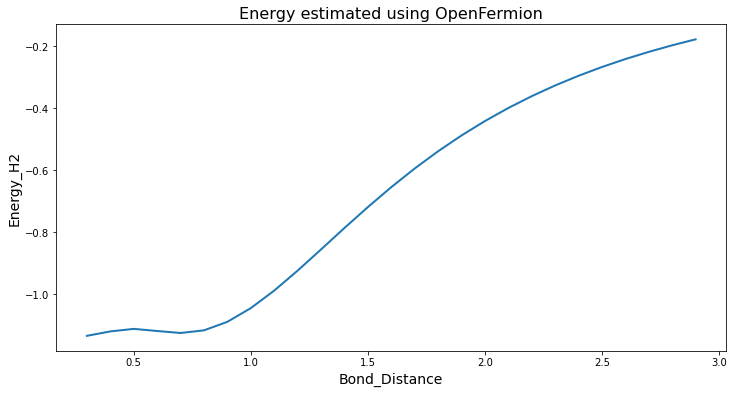

In [123]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = [12,6], facecolor='white')
plt.plot(distances, Ener,linewidth=2)
plt.title('Energy estimated using OpenFermion', fontsize = 16)
plt.xlabel(fr'Bond_Distance', fontsize = 14)
plt.ylabel(fr'Energy_H2', fontsize = 14)
plt.show()